# Permutacja macierzy rzadkich

**Maciej Skoczeń**, **Kacper Kafara**

grupa wtorek (A) 17:50

## Środowisko obliczeniowe

Procesor: Intel i7-9750H @ 2,6 GHz; 6 rdzeni fizycznych (12 log.)\
Pamięć RAM: 16 GB

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import subprocess
import matplotlib.pyplot as plt
import platform
from IPython.display import Image, display
import pydot

from timeit import default_timer
from math import sqrt

Array = np.ndarray

## Funkcje pomocnicze

In [3]:
class Timer(object):
    def __init__(self):
        self._start_time = None
        self._stop_time = None

    def start(self):
        self._start_time = default_timer()

    def stop(self):
        self._stop_time = default_timer()

    @property
    def elapsed(self, val = None):
        if self._stop_time is None or self._start_time is None:
            return None
        elapsed = self._stop_time - self._start_time
        return elapsed
    

# mock impl
def is_int(value) -> bool:
    as_int = int(value)
    return value == as_int

###  Wczytywanie macierzy

wygenerowanej za pomocą dostarczonego skryptu `mass_matrix`, przepisanego do C++ (credit: Arkadiusz Wolk)

In [4]:
def input_matrix(octave_matrix, n, m, q=1):
    result = np.zeros((n*q, m*q), dtype=np.double)
    
    for elem in octave_matrix:
        m = re.match(r"\s*\((\d+),\s*(\d+)\)\s*->\s*(\d+\.\d+)\s*", elem)
        if m is not None:
            x, y, value = m.groups()
        elif len(elem) > 0:
            coord, value = elem.strip().split(' -> ')
            value = float(value)
            x, y = coord.split(',')
            x, y = x[1:], y.strip()[:-1]
        else:
            continue
        
        for i in range(q):
            for j in range(i + 1):
                result[i*n + int(x) - 1, j*n + int(y) - 1] = float(value)
        
    return result

In [5]:
def load_octave_matrix(filename):
    with open(filename, "r") as file:
        return file.readlines()

In [6]:
data_dir = "../../output"

def resolve_path(matrix_type, width, height = None, generate = False):
    if height is None: height = width
    path = f"{data_dir}/{matrix_type}-{width}x{height}.txt"
    if os.path.isfile(path): return path
    elif not generate:
        raise FileNotFoundError(f"Matrix file {path} was not found in data dir.")
    else: 
        if platform.system() == "Windows":
            raise FileNotFoundError(f"Matrix file {path} was not found in data dir.\
                Automated generation is not supported on your platform: {platform.system()}.")

        if width != height:
            raise ValueError("Can only generate square matrix")
            
        generate_matrix(matrix_type, width)
        
        if os.path.isfile(path): return path
        else:
            print(path)
            raise RuntimeError("Failed to generate matrix")

In [7]:
def resolve_matrix(matrix_type, n, m, q = 1, generate = False):
    return input_matrix(
        load_octave_matrix(resolve_path(matrix_type, n, m, generate = generate)), n, m, q)

In [8]:
def generate_matrix(matrix_type, rank):
    if matrix_type not in {'iga', 'fem'}:
        raise ValueError(f"Invalid matrix type: {matrix_type}")
        
    if rank < 16 or not is_int(sqrt(rank)):
        raise ValueError(f"Invalid matrix rank: {rank}. Must be >= 16 and sqrt(rank) must be of type integer.")
        
    rank_root = int(sqrt(rank))
    
    if matrix_type == 'fem':
        for p in range(2, 5):
            double_nxx = rank_root - p + 1
            if double_nxx % 2 == 0 and double_nxx // 2 >= 2:
                nxx = double_nxx // 2
                pxx = p
                break
        else:
            raise RuntimeError(f"Failed to determine nxx, pxx for rank: {rank}")
    else:
        for p in range(2, 5):
            nxx = rank_root - p
            if nxx >= 2:
                pxx = p
                break
        else:
            raise RuntimeError(f"Failed to determine nxx, pxx for rank: {rank}")
    
    cwd = os.getcwd()
    os.chdir(os.getenv('SCRIPTS_DIR'))
    !./generate-matrix.sh cpp {matrix_type} {nxx} {pxx} 0
    os.chdir(cwd)

## Implementacja formatu CSR

In [10]:
class CSRMatrix:
    def __init__(self, matrix: Array = None):
        self.non_zero_values_count = 0
        self.N = 0 # wysokość/szerokość macierzy
        self.column_indices = []
        self.values = []
        if matrix is not None:
            self.from_dense(matrix)
    
    def from_dense(self, matrix_dense: Array):
        self.N = matrix_dense.shape[0]
        for i in range(self.N): # wiersze
            self.column_indices.append([])
            self.values.append([])
            for j in range(self.N): # kolumny
                if matrix_dense[i,j] != 0:
                    self.non_zero_values_count += 1
                    self.column_indices[i].append(j)
                    self.values[i].append(matrix_dense[i,j])
    
    def to_dense(self):
        result = np.zeros((self.N, self.N), dtype=np.double)
        for r in range(self.N):
            for i, c in enumerate(self.column_indices[r]):
                result[r, c] = self.values[r][i]
        return result

## Eliminacja Gaussa dla macierzy w formacie CSR

In [13]:
def sparse_gaussian_elimination(M: CSRMatrix, timer: Timer = None) -> None:
    N = M.N
    eps = 10e-16
    if timer: timer.start()
        
    for k in range(N - 1): # iterowanie po przekątnej macierzy
        # znajdujemy wyraz na przekątnej
        # k_row_start = M.row_beginning_indices[k]
        k1_row_end = len(M.values[k])
        
        # zakładam, że wartość na przekątnej jest niezerowa
        # wtedy wartość na przekątnej jest pierwszą niezerową
        # wartością w wierszu
        M_kk = M.values[k][0]
        for i in range(len(M.values[k])):
            M.values[k][i] /= M_kk
        
        # iterujemy po wierszach poniżej przekątnej
        for j in range(k + 1, N):
            first_non_zero_col_ind_j = M.column_indices[j][0]
            if first_non_zero_col_ind_j != k: continue # <=> M_jk == 0
            
            # j_row_start = M.row_beginning_indices[j]
            j1_row_end = len(M.values[j])
                
            M_jk = M.values[j][0]
            
            k_iter = 0
            j_iter = 0
            while k_iter < k1_row_end and j_iter < j1_row_end:
                k_col = M.column_indices[k][k_iter]
                j_col = M.column_indices[j][j_iter]
                
                # insert i pop działają szybciej mimo pesymistycznych czasów O(n)
                # od bardziej skomplikowanych sposobów redukcji złożoności
                if k_col == j_col: # jeżeli ta sama kolumna, to aktualizujemy wartość
                    M.values[j][j_iter] -= M_jk * M.values[k][k_iter]
                    if abs(M.values[j][j_iter]) < eps:
                        M.values[j].pop(j_iter)
                        M.column_indices[j].pop(j_iter)
                        M.non_zero_values_count -= 1
                        j1_row_end -= 1
                    else:
                        j_iter += 1
                    k_iter += 1
                elif k_col < j_col: # potrzebujemy wstawić wartość przed j_col
                    val = -(M_jk * M.values[k][k_iter])
                    if abs(val) >= eps:
                        M.non_zero_values_count += 1
                        M.values[j].insert(j_iter, val)
                        M.column_indices[j].insert(j_iter, k_col)
                        j_iter += 1 # przesuwamy na element wskazywany przed wstawieniem
                        j1_row_end += 1
                    k_iter += 1
                else: # jeżeli indeks góry jest > niż dołu, to wartość zostaje niezmieniona
                    j_iter += 1
            
            for i in range(k_iter, k1_row_end):
                val = -(M_jk * M.values[k][i])
                if abs(val) >= eps:
                    M.values[j].insert(j_iter, val)
                    M.column_indices[j].insert(j_iter, M.column_indices[k][i])
                    j_iter += 1
                    M.non_zero_values_count += 1

    if timer: timer.stop()

## Generowanie grafu eliminacji dla macierzy i generowanie orderingu algorytmem minimum degree

In [14]:
# Graf eliminacji skierowany
class EliminationGraph:
    def __init__(self, matrix=None, is_sparse=False):
        self.succ = [] # Zbiory następników wierzchołków
        self.pred = [] # Zbiory poprzedników wieszchołków
        if matrix is None:
            self.N = 0
        elif is_sparse:
            self.from_sparse(matrix)
        else:
            self.from_dense(matrix)
    
    def from_dense(self, matrix_dense : Array):
        N = matrix_dense.shape[0]
        self.N = N
        self.succ = [set() for _ in range(N)]
        self.pred = [set() for _ in range(N)]
        for i in range(N):
            for j in range(N):
                if i == j: continue
                if matrix_dense[i][j] != 0: # i -> j
                    self.succ[j].add(i)
                    self.pred[i].add(j)
    
    def from_sparse(self, matrix_sparse : CSRMatrix):
        N = matrix_sparse.N
        self.N = N
        self.succ = [set() for _ in range(N)]
        self.pred = [set() for _ in range(N)]
        for i in range(N):
            for j in matrix_sparse.column_indices[i]:
                if i == j: continue
                # i -> j
                self.succ[j].add(i)
                self.pred[i].add(j)
    
    def draw(self):
        PG = "strict digraph  {\n"
        for v in range(self.N):
            for u in self.succ[v]:
                if v in self.pred[u]:
                    if u <= v: continue
                    PG += f"{v} -> {u} [dir=both]\n"
                else:
                    PG += f"{v} -> {u}\n"
        PG += "}"
        PG = pydot.graph_from_dot_data(PG)[0]
        plt = Image(PG.create_png())
        display(plt)
    
    def minimum_degree_ordering(self):
        ordering = [] # Wynikowy ordering
        vertices = set([v for v in range(self.N)]) # Zbiór dostępnych wierzchołków
        succ = self.succ.copy()
        pred = self.pred.copy()
        
        for _ in range(self.N):
            min_degree = float("inf") # Szukamy niewykorzystanego wierzchołka p o najmniejszym stopniu
            p = -1
            for v in vertices:
                d = len(succ[v]) # stopień wierzchołka v
                if d < min_degree:
                    p = v
                    min_degree = d
            vertices.remove(p)
            ordering.append(p)
            
            # Aktualizowanie zbioru następników dla poprzedników wierzchołka p
            for v in pred[p]: # v -> p
                # succ[v] = succ[v] v succ[p] - {p}
                succ[v] = succ[v].union(succ[p])
                if p in succ[v]:
                    succ[v].remove(p)
            
            # Aktualizowanie zbioru poprzedników dla następników wierzchołka p
            for u in succ[p]: # p -> u
                # pred[u] = pred[u] v pred[p] - {p}
                pred[u] = pred[u].union(pred[p])
                if p in pred[u]:
                    pred[u].remove(p)
            
        return ordering

## Permutacja macierzy

In [15]:
def matrix_permutation(matrix : Array, ordering):
    N = matrix.shape[0]
    perm = np.zeros((N, N), dtype=bool)
    for i, o in enumerate(ordering):
        perm[i, o] = True
    # P * A * P^T
    return perm @ matrix @ perm.T

## Generowanie macierzy

In [16]:
# Generowanie macierzy "trójkątnej dolnej"
def create_triangular(matrix : Array, q=1):
    N = matrix.shape[0]
    result = np.zeros((q*N, q*N), dtype=np.double)
    for i in range(q):
        for j in range(i + 1):
            result[i*N:(i + 1)*N, j*N:(j + 1)*N] = matrix
    return result

In [19]:
# A_n = 784 # liczba wierszy i kolumn macierzy A
# A = resolve_matrix('fem', A_n, A_n, generate=True)
A_n = 784
A = input_matrix(load_octave_matrix(data_dir + "/fem_m.txt"), A_n, A_n)
B = create_triangular(A, 5)

Macierz A to macierz 784x784 wygenerowana z parametrami: massmatrix(1, 13, 3, 0). Dodatkowo, wygenerowaliśmy macierz B powtarzając kilkukrotnie macierz A dla skomplikowania działania eliminacji dla macierzy rzadkich.

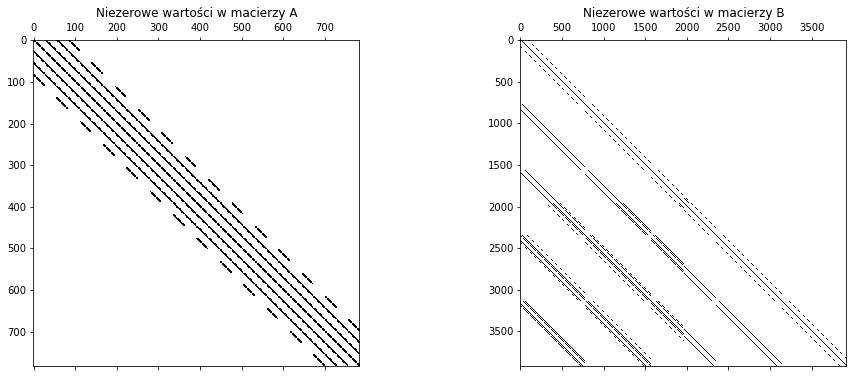

In [20]:
_, (ax_A, ax_B) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax_A.set_title('Niezerowe wartości w macierzy A')
ax_A.spy(A)
ax_B.set_title('Niezerowe wartości w macierzy B')
ax_B.spy(B)
plt.show()

## Konstruowanie grafu eliminacji G0 dla macierzy A0 = A[:50, :50] (o wymiarach 50x50)

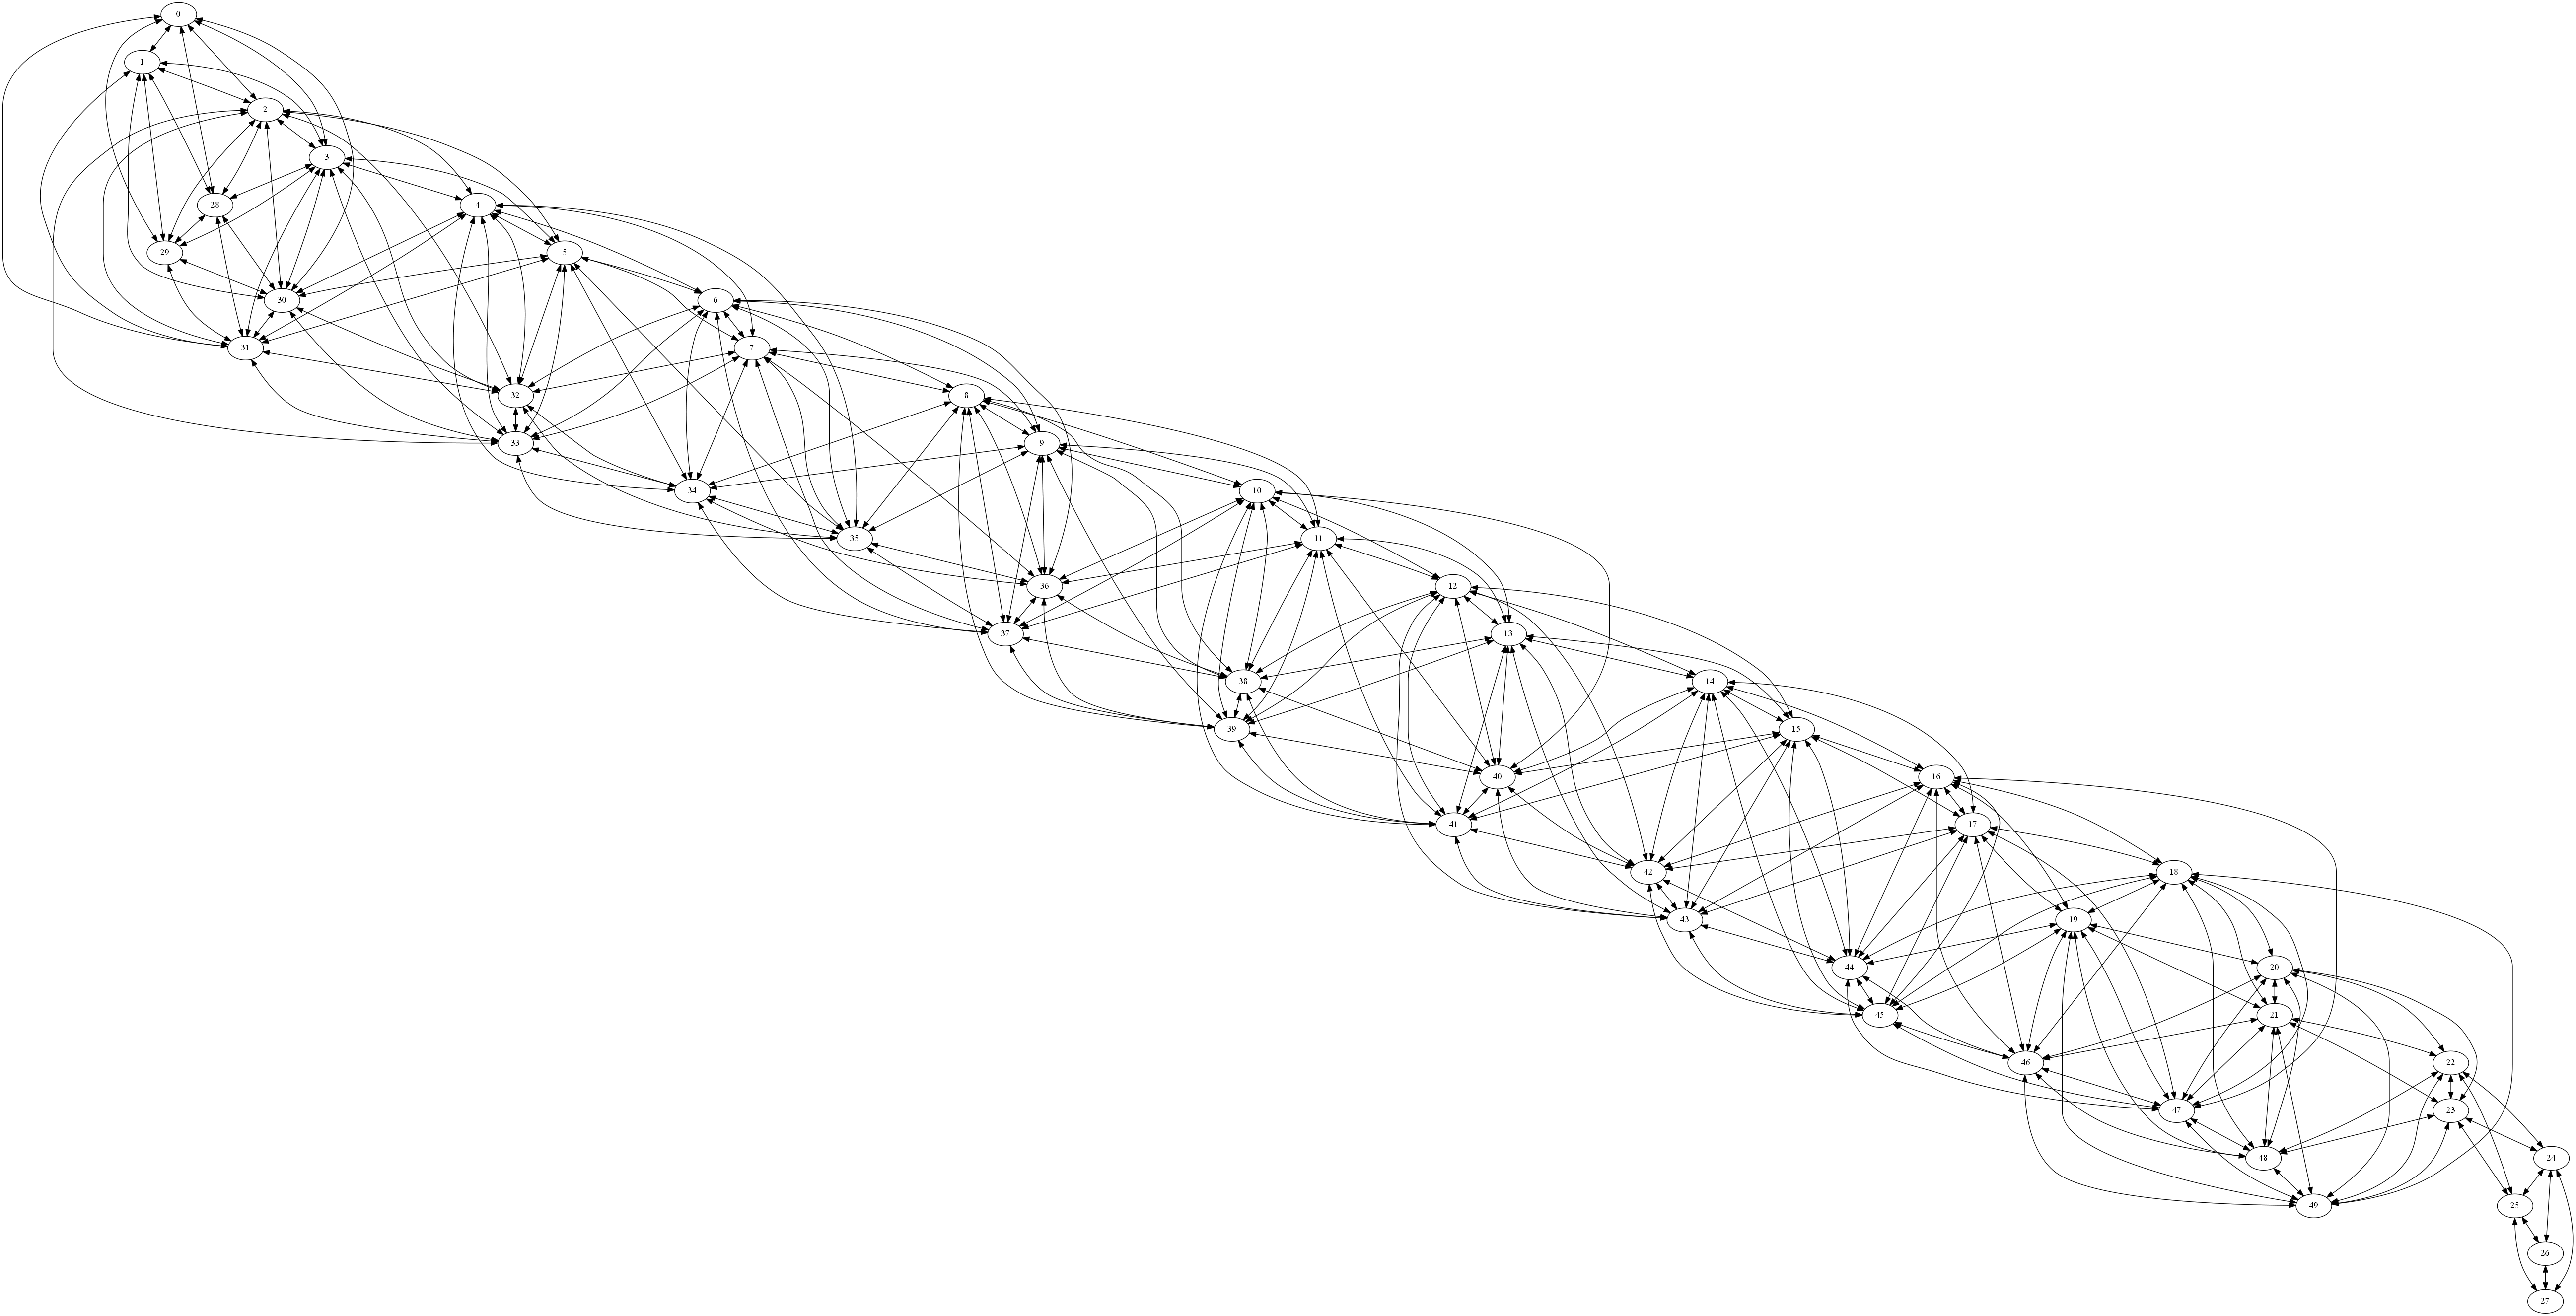

In [21]:
A0 = A[:50, :50]
G0 = EliminationGraph(A0)
G0.draw()

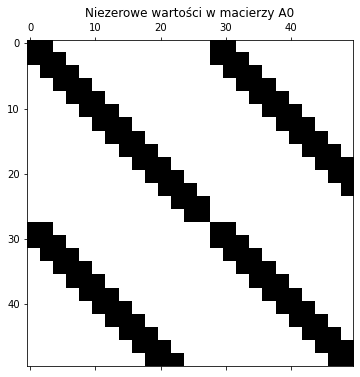

In [22]:
plt.figure(figsize=(8,6))
plt.title('Niezerowe wartości w macierzy A0')
plt.spy(A0)
plt.show()

## Eliminacja Gaussa dla macierzy A0

In [23]:
A0_sparse = CSRMatrix(A0)
sparse_gaussian_elimination(A0_sparse)
G0n = EliminationGraph(A0_sparse, True)
G0n.draw()

Brak narysowanego grafu eliminacji oznacza poprawne działanie algorytmu.

## Konstruowanie grafu eliminacji G1 dla macierzy A1 będącej spermutowaną macierzą A0

In [25]:
ordering = G0.minimum_degree_ordering()

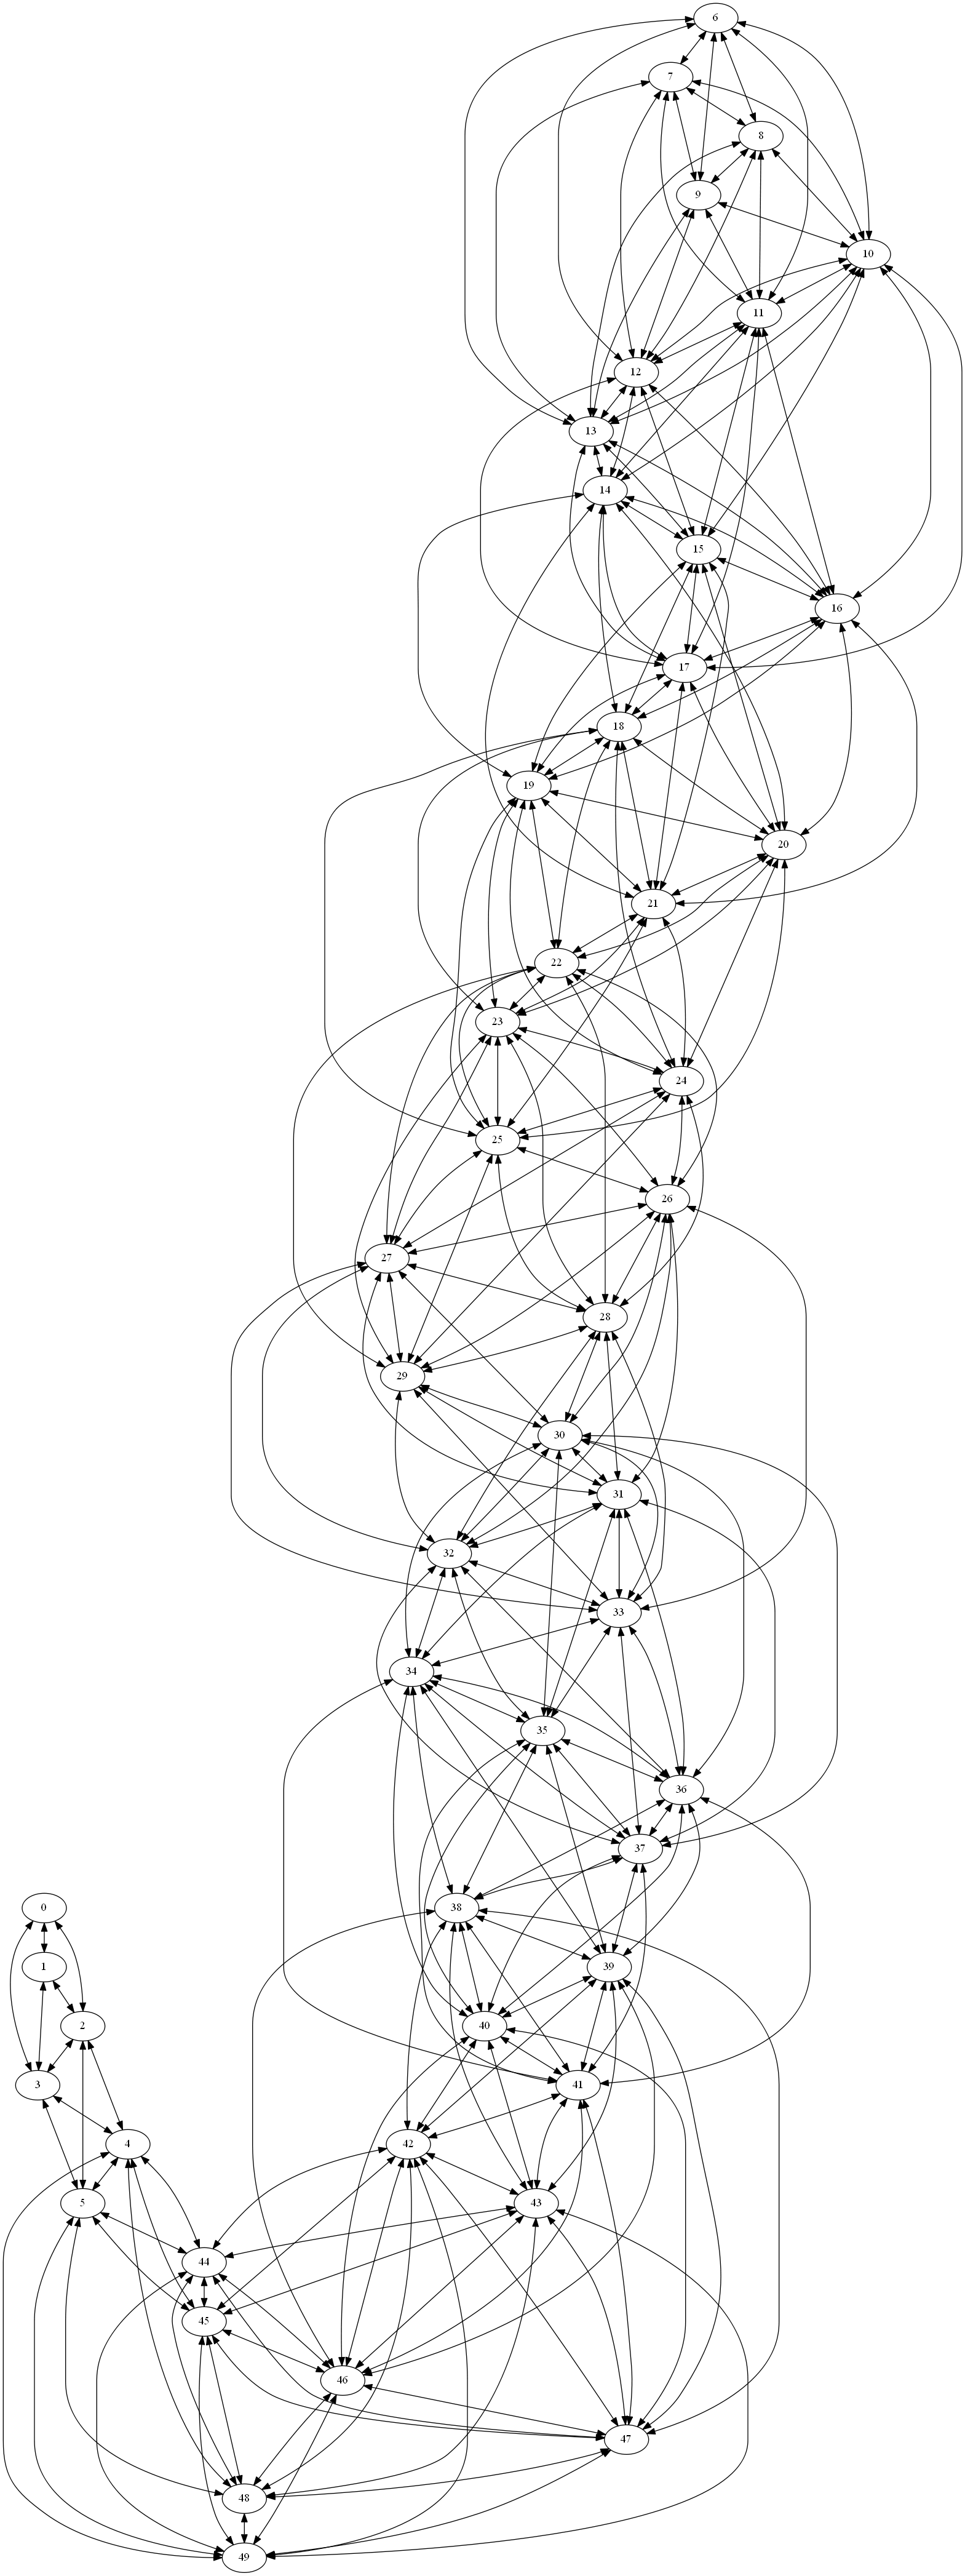

In [21]:
A1 = matrix_permutation(A0, ordering)
G1 = EliminationGraph(A1)
G1.draw()

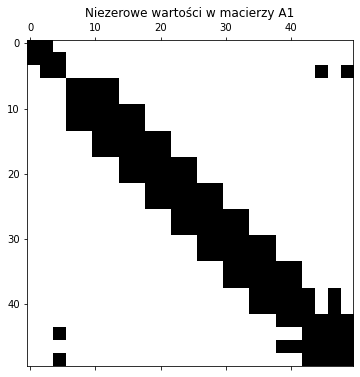

In [25]:
plt.figure(figsize=(8,6))
plt.title('Niezerowe wartości w macierzy A1')
plt.spy(A1)
plt.show()

## Eliminacja Gaussa dla macierzy A1

In [54]:
A1_sparse = CSRMatrix(A1)
sparse_gaussian_elimination(A1_sparse)
G1n = EliminationGraph(A1_sparse, True)
G1n.draw()

Tutaj również brak narysowanego grafu oznacza poprawną eliminację.

## Permutacja całej macierzy A

In [26]:
G_A = EliminationGraph(A)
A_perm = matrix_permutation(A, G_A.minimum_degree_ordering())

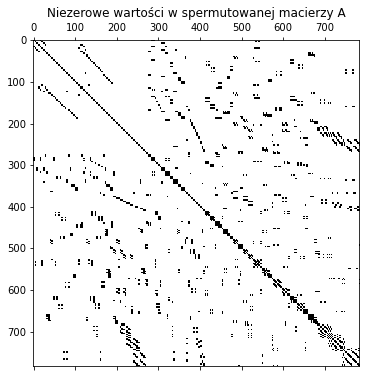

In [27]:
plt.figure(figsize=(8,6))
plt.title('Niezerowe wartości w spermutowanej macierzy A')
plt.spy(A_perm)
plt.show()

## Permutacja całej macierzy B

In [28]:
G_B = EliminationGraph(B)
B_perm = matrix_permutation(B, G_B.minimum_degree_ordering())

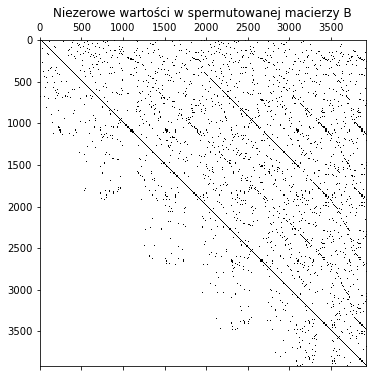

In [29]:
plt.figure(figsize=(16,6))
plt.title('Niezerowe wartości w spermutowanej macierzy B')
plt.spy(B_perm)
plt.show()

## Porównanie czasów wykonania eliminacji dla macierzy rzadkich przed permutacją i po permutacji

In [59]:
def elimination_time_test(M : Array, n_tests=1, return_sparse=False):
    timer = Timer()
    exec_time = 0
    for test_no in range(n_tests):
        M_sparse = CSRMatrix(M)

        sparse_gaussian_elimination(M_sparse, timer)
        exec_time += timer.elapsed
        
    exec_time /= n_tests
    if return_sparse:
        return exec_time, M_sparse
    return exec_time

In [62]:
n_tests = 1

A_time = elimination_time_test(A, n_tests)
print(f'Średni czas wykonania eliminacji dla macierzy A:               {A_time:.5f}s')

A_perm_time = elimination_time_test(A_perm, n_tests)
print(f'Średni czas wykonania eliminacji dla spermutowanej macierzy A: {A_perm_time:.5f}s')

B_time = elimination_time_test(B, n_tests)
print(f'Średni czas wykonania eliminacji dla macierzy B:               {B_time:.5f}s')

B_perm_time = elimination_time_test(B_perm, n_tests)
print(f'Średni czas wykonania eliminacji dla spermutowanej macierzy B: {B_perm_time:.5f}s')

Średni czas wykonania eliminacji dla macierzy A:               3.94675s
Średni czas wykonania eliminacji dla spermutowanej macierzy A: 3.13405s
Średni czas wykonania eliminacji dla macierzy B:               214.25139s
Średni czas wykonania eliminacji dla spermutowanej macierzy B: 49.64289s


Widać, że dla macierzy A uzyskane czasy sa bardzo podobne. Zapewne jest tak, dlatego że elementy tej macierzy znajdują się blisko przekątnej i permutacja nie ma tutaj dużego pola do poprawy.    
Inaczej jest z macierzą B, gdzie spadek jest wyraźny. W tym przypadku permutacja okazała się bardzo opłacalną operacją.    
Trzeba też pamiętać, że permutacja uzyskana algorytmem minimum degree nie jest zawsze optymalna.